## This notebook demonstrates Shapely values for interpreting xgboost model


In [1]:
import numpy as np
import pandas as pd
import xgboost 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import shap
import sklearn

In [2]:
import seaborn as sns
import os
import sys


## Data for this demo is taken from kaggle competition - https://www.kaggle.com/c/mercedes-benz-greener-manufacturing

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.describe()

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
count,4209.000000,4209.000000,4209.000000,4209.0,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,...,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000,4209.000000
mean,4205.960798,100.669318,0.013305,0.0,0.075077,0.057971,0.428130,0.000475,0.002613,0.007603,...,0.318841,0.057258,0.314802,0.020670,0.009503,0.008078,0.007603,0.001663,0.000475,0.001426
std,2437.608688,12.679381,0.114590,0.0,0.263547,0.233716,0.494867,0.021796,0.051061,0.086872,...,0.466082,0.232363,0.464492,0.142294,0.097033,0.089524,0.086872,0.040752,0.021796,0.037734
min,0.000000,72.110000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2095.000000,90.820000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4220.000000,99.150000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6314.000000,109.010000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8417.000000,265.320000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## We seperate out numeric and categorical columns

In [6]:
num_cols = df.describe().columns.values.tolist()

In [7]:
num_cols.remove('ID')
num_cols.remove('y')

In [8]:
cat_cols = df.select_dtypes(include = ['object']).columns.values.tolist()

In [9]:
cat_cols

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

### Split data into train and test set . Objective is to predict time it takes to pass testing for a car, so dependent variable is continuous one.

In [10]:
x_train,x_test,y_train,y_test = train_test_split(df[num_cols+cat_cols],df['y'],random_state=42,test_size=0.2)

In [11]:
df['y'].value_counts()

90.76     7
89.06     7
89.38     7
91.88     7
93.62     6
         ..
93.26     1
93.24     1
105.94    1
94.17     1
79.00     1
Name: y, Length: 2545, dtype: int64

### Sklearn has useful features for data imputation and  transformation. Use of pipeline class allows us to chain imputations followed by scaling of features for both categorical and numerical features.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


### Pipeline can specify which model to train. We have selected Xgboost regressor for this demo. Following hyperparameters were obtained after few trial runs. Model has low enough RMSE to use for shapely demo.

In [63]:
num_transform = Pipeline(steps=[('Imputer',SimpleImputer(strategy='mean')),
                               ('Scaling', MinMaxScaler())])

cat_transform = Pipeline(steps=[('Imputer',SimpleImputer(strategy='constant',fill_value='missing')),
                               ('onehot',OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(transformers=[('num',num_transform,num_cols),
                                            ('cat',cat_transform,cat_cols)])

model = Pipeline(steps=[('prepro',preprocess),
                     ('regressor',xgboost.XGBRegressor(max_depth=6,n_estimators=200,reg_lambda=10))])

pre_pro = Pipeline(steps = [('pre',preprocess)])

In [64]:
model.fit(x_train,y_train)

Series.base is deprecated and will be removed in a future version


[20:49:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('prepro',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('Imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                                     

In [65]:
from sklearn.metrics import mean_squared_error

In [66]:
y_pred = model.predict(x_test)

In [67]:
np.sqrt(mean_squared_error(y_pred,y_test))

8.132442942766284

### Lower RMSE is also validated with scatter plots and distribution of diffrenece in prediction and actual labels. 

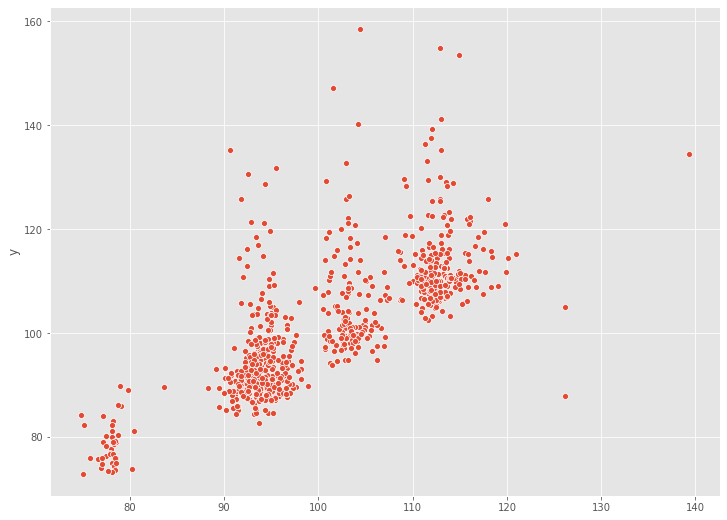

In [68]:
sns.scatterplot(y_pred,y_test)


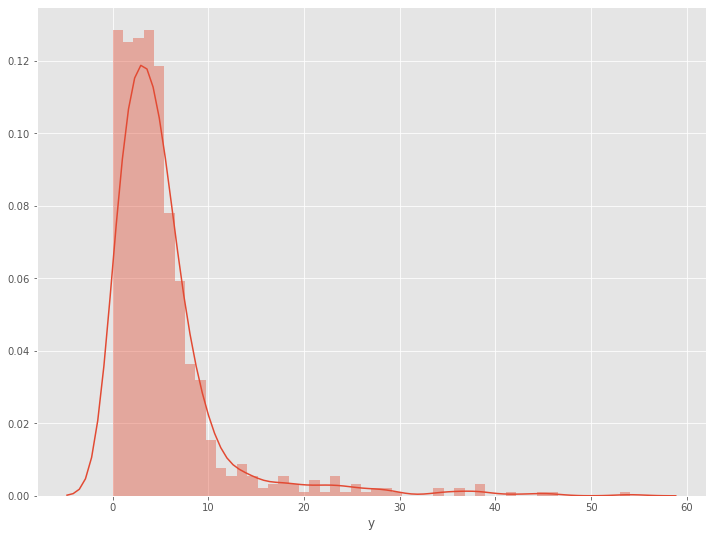

In [69]:
sns.distplot(np.abs(y_pred-y_test))


### Build Regression tree on entire dataset ###

In [70]:
transformed_input = pre_pro.fit_transform(df[num_cols+cat_cols])

In [71]:


#fit on train dataset#
train_transformed = pre_pro.fit_transform(x_train)
test_transformed = pre_pro.transform(x_test)
reg_model = xgboost.XGBRegressor(colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=None, n_estimators=200, n_jobs=1,
                              nthread=None, objective='reg:linear',
                              random_state=0, reg_alpha=0, reg_lambda=10,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1)

#reg_model.fit(train_transformed,y_train)

In [72]:
new_cat_cols=pre_pro['pre'].transformers_[1][1]['onehot']\
                         .get_feature_names(cat_cols)

In [23]:
len(list(np.append(num_cols,new_cat_cols)))

561

In [74]:
reg_model.fit(transformed_input,df['y'])

Series.base is deprecated and will be removed in a future version
Series.base is deprecated and will be removed in a future version


[20:50:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

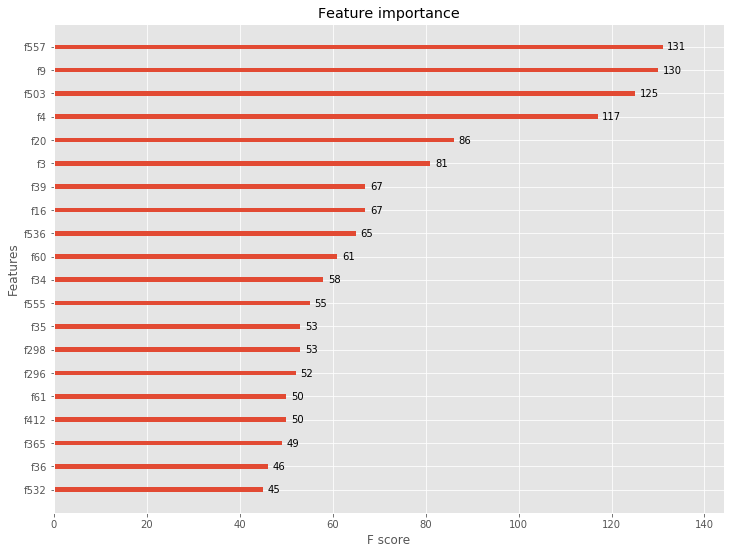

In [75]:
from xgboost import plot_importance
plot_importance(reg_model,max_num_features=20)


### Shapely Plots ###
#### Shapley values are generated for each individual prediction. In simple terms they help us breakdown contribution of each feature value towards final prediction. 
#### A linear additive model is built to derive each feature's share in model output. 
#### Shap package in python helps visualaizing these contributions. 

In [76]:
shap_values = shap.TreeExplainer(reg_model).shap_values(transformed_input)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

In [79]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)

plt.rcParams['figure.figsize'] = (12, 9)
plt.style.use('ggplot')

shap.initjs()

### Following shap summary plot shows ###
#### 1. SHAP value on X axis i.e. impact on model output for higher or lower values for particular feature
#### 2. Feature names are displayed along Y axis
#### 3. We can clearly see feature 298,503 lead to longer test time when their values are higher
#### 4. Features which have less impact on predictions have values clustered close to 0 shap value. 


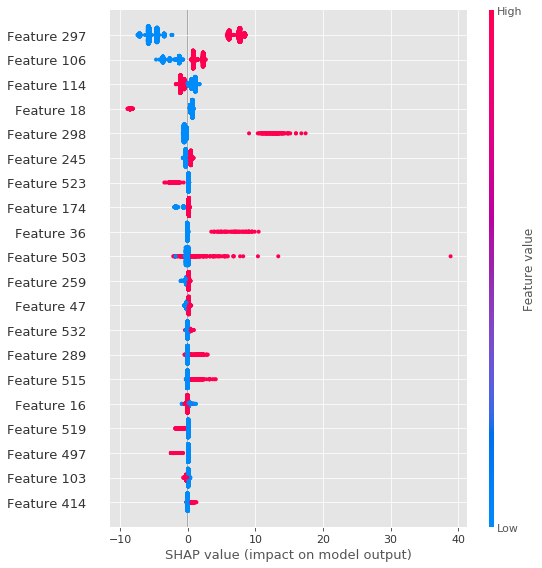

In [80]:
shap.summary_plot(shap_values,transformed_input)